# P5 - Data Processing

In [1]:
import pandas as pd
import numpy as np

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings('ignore')

In [2]:

docs = pd.read_csv("QueryResults.csv")

In [3]:
docs.set_index('Id').sort_index()

,Title,Body,Tags,Score,ViewCount,FavoriteCount,AnswerCount
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,759,64063,58,12
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,1612,188799,552,41
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,673,248432,157,27
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,341,63943,86,23
88,Is gettimeofday() guaranteed to be of microsec...,"<p>I am porting a game, that was originally wr...",<linux><winapi><visual-c++><unix><timer>,104,43767,19,10
...,...,...,...,...,...,...,...
69729326,Endless sine generation in C,<p>I am working on a project which incorporate...,<c><performance><time><precision><trigonometry>,91,10074,25,12
69832748,"Error ""Error: A <Route> is only ever to be use...",<p>I am trying to use routing for the first ti...,<javascript><node.js><reactjs><frameworks><rea...,57,77406,13,14
69875125,find_element_by_* commands are deprecated in s...,<p>When starting the function</p>\n<pre><code>...,<python><selenium><selenium-webdriver><webdriv...,52,59346,25,3


In [4]:
docs.drop(['Id', 'Score', 'ViewCount', 'FavoriteCount','AnswerCount'], axis=1, inplace=True)

## Data Preparation


### Tags preprocessing

In [5]:
# tokenize the tags
def tokenizeTags(tags):
    """
    Remove some unwanted characters
    """
    tags = tags.replace('<', ' ')
    tags = tags.replace('>', '')
    return tags.strip().split(' ')


In [6]:

docs['Tags'] = docs['Tags'].apply(tokenizeTags)

In [7]:
MAX_TAGS = 200
# get 200 most frequent tags
def getMostFrequentTags(df: pd.DataFrame, col: str, max_tags_count = MAX_TAGS) -> pd.DataFrame:
    all_tags = [item for sublist in df[col] for item in sublist]
    unique, counts = np.unique(all_tags, return_counts=True)
    return pd.DataFrame({'word': unique, 'count':counts}).sort_values('count', ascending=False)[:max_tags_count]

common_tags = getMostFrequentTags(docs, 'Tags').word.values
common_tags[:10]

array(['java', 'python', 'javascript', 'c#', 'ios', 'android', 'c++',
       '.net', 'iphone', 'objective-c'], dtype=object)

In [8]:
# filter tags of each document to restrict to most common
def get_most_tag(row):
    return [tag for tag in row if tag in common_tags]

docs_tags = docs['Tags'].apply(get_most_tag)
docs['tags'] = docs_tags

In [9]:
type(np.array(docs_tags[0]))
type(docs_tags[0])
docs_tags[:10]

numpy.ndarray

list

0                             [javascript]
1                                    [c++]
2                         [c#, .net, linq]
3    [c++, performance, optimization, stl]
4                                [c, file]
5                 [c#, .net, web-services]
6        [c#, .net, performance, datetime]
7                        [algorithm, math]
8                                [windows]
9                  [html, sql, sql-server]
Name: Tags, dtype: object

In [10]:
with open('common_tags', 'wb') as v :
    pickle.dump(common_tags, v)

In [11]:
with open('docs_tags', 'wb') as v :
    pickle.dump(docs['Tags'].apply(get_most_tag), v)

### Word Cloud

In [12]:
# TODO WIP
# from wordcloud import WordCloud
#
# words = str([tag for row in docs.tags for tag in row])
# # Create a WordCloud object
# wordcloud = WordCloud(background_color="white", max_words=200, contour_width=3, contour_color='steelblue')
# # Generate a word cloud
# wordcloud.generate(words)
# # Visualize the word cloud
# wordcloud.to_image()

### Words preprocessing

In [13]:
# add title into the body
docs['body'] = docs['Title'] + '\n' + docs['Body']

#### Remove code snippets

In [14]:
from bs4 import BeautifulSoup

def remove_code_snippets(docs):
    """
    Remove code snippets from docs
    surrounded by <pre> tags
    """
    # ensure '<' & '>' chars are set, not the unicode char
    docs = docs.apply(lambda d: d.replace('&lt;', '<').replace('&gt;', '>'))
    ret = []
    for doc in docs:
        soup = BeautifulSoup(doc, 'html.parser')
        removals = soup.find_all('pre')
        for pre in removals:
            pre.decompose()
        ret.append(soup.get_text())
    return ret


In [15]:
docs.body = remove_code_snippets(docs.body)

#### Remove Stop words, Lemmatize, Stemmize, Tokenize

In [16]:
# remove stop words
# lemmatize (convert and remove prefixes and suffixes to ignore the gender, plural, verb : walking, walks, walked, walk -> walk)
# and/or stemmize (take the same root of words : universal / university -> univers)

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer

stopwords = set(stopwords.words('english'))
filtre_stopw =  lambda text: [token.lower() for token in text if token.lower() not in stopwords]

# replace words with stem
def tokenize_sw_stem(doc):
    tokenizer = nltk.RegexpTokenizer(r'\w+')
    stemmer = EnglishStemmer()
    filtered = filtre_stopw(tokenizer.tokenize(doc))
    ret = " ".join([stemmer.stem(s) for s in filtered] )
    return ret

# replace words with lem
def tokenize_sw_lem(doc):
    lemmatizer = WordNetLemmatizer()
    filtered = filtre_stopw(nltk.tokenize.word_tokenize(doc))
    # filtered = filtre_stopw(tokenizer.tokenize(doc))
    ret = " ".join([lemmatizer.lemmatize(s) for s in filtered] )
    # TODO manage .net token
    # manage c# token
    ret = re.sub(r'c #', 'c#', ret)
    # temp
    # ret = re.sub(r' #', '', ret)
    # ret = re.sub(r'# ', '', ret)

    # removes punctuation, comes from string.punctuation, without some special characters present into the tags (c#, c++, objective-c, )
    ret = ret.translate(str.maketrans('', '', r"""!"$%&'()*,/:;<=>?@[\]^_`{|}~"""))
    # removes all non-word
    ret = re.sub(' \W+ ',' ', ret)

    # remove single char, except 'c', 'r'
    # ret = re.sub(r'\s[abd-qs-z]{1}\s', ' ', ret)
    ret = re.sub(r'\s[abd-q]{1}\s', ' ', ret)
    ret = re.sub(r'\s[s-z]{1}\s', ' ', ret)
    ret = re.sub(r'\s\+{1}', ' ', ret)

    # ret = re.sub(r'\s[abd-qs-z]{1}\s', ' ', ret)
    # ret = re.sub(r'\s[s-z]{1}', ' ', ret)
    # remove double or more spaces
    ret = re.sub(r' {2,}', ' ', ret)
    return ret


# words_stem = list(map(tokenize_sw_stem, docs.body))
# words_lem = list(map(tokenize_sw_lem, docs.body))

# test

test_string = "this is a test string. Contains with __ chars and c++, C# tags, java, .net, r language, c lang , ; and some isolated letters a b c d e z x end signs + "
tokenize_sw_lem(test_string)

print('C#')
index = 3632
docs.body[index]
tokenize_sw_lem(docs.body[index])

print('c++')
index = 70
docs.body[index]
tokenize_sw_lem(docs.body[index])

print('.net')
index = 1460
docs.body[index]
tokenize_sw_lem(docs.body[index])

print('MISC')
index = 203
docs.body[index]
tokenize_sw_lem(docs.body[index])

'test string contains char c++ c# tag java .net r language c lang isolated letter c x end sign '

C#


"c# - WebRequest HTTP POST with Cookie (port from curl script)\nThe IBM RTC RESTful api gives an example of a shell script for authenticating with the server:\n\nThis works perfectly, however i need to authenticate with the server using c#.\nSo far i have the following, but it isn't working (returns the authorization failed page):\n\n"

'c# webrequest http post cookie port curl script ibm rtc restful api give example shell script authenticating server work perfectly however need authenticate server using c# far following nt working return authorization failed page '

c++


'Test Automation with Embedded Hardware\nHas anyone had success automating testing directly on embedded hardware?\nSpecifically, I am thinking of automating a battery of unit tests for hardware layer modules. We need to have greater confidence in our hardware layer code. A lot of our projects use interrupt driven timers, ADCs, serial io, serial SPI devices (flash memory) etc..\nIs this even worth the effort?\nWe typically target:\nProcessor: 8 or 16 bit microcontrollers (some DSP stuff)\nLanguage: C (sometimes c++).  \n'

'test automation embedded hardware anyone success automating testing directly embedded hardware specifically thinking automating battery unit test hardware layer module need greater confidence hardware layer code lot project use interrupt driven timer adcs serial io serial spi device flash memory etc even worth effort typically target processor 8 16 bit microcontrollers dsp stuff language c sometimes c++ .'

.net


".NET Web API 2 OWIN Bearer Token Authentication\nI'm implementing a Web API 2 service architecture in my .NET web application.  The client consuming the requests is pure javascript, no mvc/asp.net.  I'm using OWIN to try to enable token authentication per this article OWIN Bearer Token Authentication with Web API Sample.  I seem to be missing something with the authentication step after its authorized.\nMy login looks like:\n\nIt returns\n\nThen I try to set the HTTP header Bearer on further requests in AngularJS like:\n\nto a API like:\n\nbut no matter what I do this service is 'unauthorized'.  Am I missing something here?\n"

'.net web api 2 owin bearer token authentication implementing web api 2 service architecture .net web application client consuming request pure javascript mvcasp.net using owin try enable token authentication per article owin bearer token authentication web api sample seem missing something authentication step authorized login look like return try set http header bearer request angularjs like api like matter service unauthorized missing something '

MISC


"Hosting the .NET runtime in a Delphi Program\nI was looking into using some .NET code from within a Delphi program, I will need to make my program extensible using .net assemblies and predefined functions (I already support regular DLLs).\nAfter a lot of searching online, I found  Managed-VCL, but I'm not ready to pay $250 for what I need, I also found some newsgroups with code that's incomplete and doesn't work.\nI'm using Delphi 2007 for win32. What can I use to dynamically execute a function from an assembly with predefined parameters?\nSomething like:\n\nI just want to add that I need to be able to load an arbitrary assemblies (maybe all the assemblies in a specific folder), so creating a C# wrapper may not work.\n"

'hosting .net runtime delphi program looking using .net code within delphi program need make program extensible using .net assembly predefined function already support regular dlls lot searching online found managed-vcl ready pay 250 need also found newsgroups code incomplete nt work using delphi 2007 win32 use dynamically execute function assembly predefined parameter something like want add need able load arbitrary assembly maybe assembly specific folder creating c# wrapper may work .'

In [17]:
# let's choose the lemmatize version of the corpus, since it results in real words that could be used as tags
docs['tokenized_body'] = list(map(tokenize_sw_lem, docs.body))

#### Remove remaining 'bad words'


In [18]:
import re

def remove_words_old(words):
    ret = []
    for word in words:
        # print(f'\nprocessing sentence: {word}\n')
        flat = re.sub(r'[0-9]+', '', word) # words that are numbers
        flat = re.sub(r'_+', '', flat) # words that contain underscores
        flat = re.sub(r'-+', '', flat) # words that contain dashes
        flat = re.sub(r'\+', '', flat)
        flat = re.sub(r'\w{15,}', '', flat) # words longer than 15 chars are most probably code (i.e. myClass.myMethodName())
        flat = " ".join(flat.split()) # remove double spaces
        # print(f'\ncurrated : {flat}')
        ret.append(flat)
    return ret

def remove_words(words):
    ret = []
    # print(f'\nprocessing sentence: {word}\n')
    flat = re.sub(r'[0-9]+', '', words) # words that are numbers
    flat = re.sub(r'_+', '', flat) # words that contain underscores
    flat = re.sub(r'-+', '', flat) # words that contain dashes
    # flat = re.sub(r'\+', '', flat)
    flat = re.sub(r'\w{15,}', '', flat) # words longer than 15 chars are most probably code (i.e. myClass.myMethodName())
    flat = " ".join(flat.split()) # remove double spaces
    # print(f'\ncurrated : {flat}')
    ret.append(flat)
    return flat

print('MISC')
index = 203
docs.body[index]
remove_words(docs.body[index])

MISC


"Hosting the .NET runtime in a Delphi Program\nI was looking into using some .NET code from within a Delphi program, I will need to make my program extensible using .net assemblies and predefined functions (I already support regular DLLs).\nAfter a lot of searching online, I found  Managed-VCL, but I'm not ready to pay $250 for what I need, I also found some newsgroups with code that's incomplete and doesn't work.\nI'm using Delphi 2007 for win32. What can I use to dynamically execute a function from an assembly with predefined parameters?\nSomething like:\n\nI just want to add that I need to be able to load an arbitrary assemblies (maybe all the assemblies in a specific folder), so creating a C# wrapper may not work.\n"

"Hosting the .NET runtime in a Delphi Program I was looking into using some .NET code from within a Delphi program, I will need to make my program extensible using .net assemblies and predefined functions (I already support regular DLLs). After a lot of searching online, I found ManagedVCL, but I'm not ready to pay $ for what I need, I also found some newsgroups with code that's incomplete and doesn't work. I'm using Delphi for win. What can I use to dynamically execute a function from an assembly with predefined parameters? Something like: I just want to add that I need to be able to load an arbitrary assemblies (maybe all the assemblies in a specific folder), so creating a C# wrapper may not work."

In [19]:
docs['tokenized_body_cleaned'] = docs.tokenized_body.apply(remove_words)


In [20]:
index = 28
docs.body[index]
docs.tokenized_body[index]
docs.tokenized_body_cleaned[index]

'How to mock window.location.href with Jest + Vuejs?\nCurrently, I am implementing unit test for my project and there is a file that contained window.location.href.\nI want to mock this to test and here is my sample code:\n\nBut I get this error:\n\nI had tried some solutions but not resolve it. I need some hints to help me get out of this trouble. Plz help.\n'

'mock window.location.href jest vuejs currently implementing unit test project file contained window.location.href want mock test sample code get error tried solution resolve need hint help get trouble plz help .'

'mock window.location.href jest vuejs currently implementing unit test project file contained window.location.href want mock test sample code get error tried solution resolve need hint help get trouble plz help .'

In [21]:
docs[docs.body.str.contains('...')]

,Title,Body,Tags,tags,body,tokenized_body,tokenized_body_cleaned
0,Mercator longitude and latitude calculations t...,<p>I have this image. It's a map of the UK (no...,"[javascript, geolocation, projection, processi...",[javascript],Mercator longitude and latitude calculations t...,mercator longitude latitude calculation croppe...,mercator longitude latitude calculation croppe...
1,Starting point for learning CAD/CAE file formats?,<p>We are developing some stress and strain an...,"[c++, file-format, autocad, cad, solid-bodies]",[c++],Starting point for learning CAD/CAE file forma...,starting point learning cadcae file format dev...,starting point learning cadcae file format dev...
2,LINQ query on a DataTable,<p>I'm trying to perform a LINQ query on a Dat...,"[c#, .net, linq, datatable, .net-3.5]","[c#, .net, linq]",LINQ query on a DataTable\nI'm trying to perfo...,linq query datatable trying perform linq query...,linq query datatable trying perform linq query...
3,How to overload std::swap(),<p><code>std::swap()</code> is used by many st...,"[c++, performance, optimization, stl, c++-faq]","[c++, performance, optimization, stl]",How to overload std::swap()\nstd::swap() is us...,overload std swap std swap used many std conta...,overload std swap std swap used many std conta...
4,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,"[c, file, directory, cross-platform, common-ta...","[c, file]",How do you get a directory listing in C?\nHow ...,get directory listing c scan directory folder ...,get directory listing c scan directory folder ...
...,...,...,...,...,...,...,...
27123,Can't perform a React state update on an unmou...,<h2>Problem</h2>\n\n<p>I am writing an applica...,"[javascript, reactjs, typescript, lodash, sets...","[javascript, reactjs, typescript]",Can't perform a React state update on an unmou...,ca nt perform react state update unmounted com...,ca nt perform react state update unmounted com...
27124,Can WPF applications be run in Linux or Mac wi...,<p>Microsoft announced .NET Core 3 comes with ...,"[linux, wpf, .net-core, desktop-application, ....","[linux, wpf]",Can WPF applications be run in Linux or Mac wi...,wpf application run linux mac .net core 3 micr...,wpf application run linux mac .net core micros...
27125,Instance of 'SQLAlchemy' has no 'Column' membe...,<p>I'm currently trying to implement steam log...,"[python, python-3.x, flask, sqlalchemy, pylint]","[python, python-3.x]",Instance of 'SQLAlchemy' has no 'Column' membe...,instance sqlalchemy column member no-member cu...,instance sqlalchemy column member nomember cur...
27126,"Why does `if None.__eq__(""a"")` seem to evaluat...",<p>If you execute the following statement in P...,"[python, python-3.x, string, boolean-expressio...","[python, python-3.x, string]","Why does `if None.__eq__(""a"")` seem to evaluat...",none.eq seem evaluate true quite execute foll...,none.eq seem evaluate true quite execute follo...


## Corpus size and Vocabulary

In [22]:
# count the total number of words in the overall corpus
# ideally would to be limited to 2000 / 3000 words maximum

VOCAB_SIZE = 2000

def get_common_vocabulary():
    lem = map(lambda x : x.split(), docs.tokenized_body_cleaned)
    flat_list = [word for sublist in list(lem) for word in sublist ]
    # len(flat_list)
    unique, counts = np.unique(flat_list, return_counts=True)
    counted_words =  pd.DataFrame({'word': unique, 'count': counts}).sort_index(ascending=False)
    
    # take the 3000 most used words in the corpus for our vocabulary
    vocabulary = pd.DataFrame({'count': counts, 'word': unique}).sort_values('count', ascending=False)[:VOCAB_SIZE].word.values
    # len(vocabulary)
    # add to vocabulary the list of common tags
    return np.unique(np.append(vocabulary, common_tags))

common_words = get_common_vocabulary()
common_words = ' '.join(common_words)
common_words = re.sub(r'\.{3}', '', str(common_words))
common_words = re.sub(r'\.{2}', '', common_words)
common_words = re.sub(r'\. ', '', common_words)
common_words = re.sub(r'[ ]{2,}', '', common_words)
common_words = np.array(common_words.split(' '))
common_words[:10]

array(['+.java', '.net', '.x', '.xml', 'a', 'ability', 'able', 'absolute',
       'absolutely', 'abstract'], dtype='<U22')

In [23]:
# reduce our corpus to the common vocabulary

def reduce_body(body):
    ret = []
    for word in body.split(' '):
        # if word in np.append(common_words, common_tags):
        if word in common_words:
            ret.append(word)
    return ' '.join(ret)

# test
# reduce_body(docs.tokenized_body[1])

docs_reduced_body = docs.tokenized_body_cleaned.apply(reduce_body)

docs['reduced_body'] = docs_reduced_body

In [24]:
docs_reduced_body_sentences = docs_reduced_body
docs_reduced_body = [np.array(doc.split()) for doc in docs_reduced_body]


In [25]:
with open('docs_reduced_body', 'wb') as v :
    pickle.dump(docs_reduced_body, v)

with open('docs_reduced_body_sentences', 'wb') as v :
    pickle.dump(docs_reduced_body_sentences, v)

In [26]:
with open('common_words', 'wb') as v :
    pickle.dump(common_words, v)

## Data Analysis

In [27]:

docs['no_tags'] = [len(t) for t in docs.tags]

<AxesSubplot:ylabel='Frequency'>

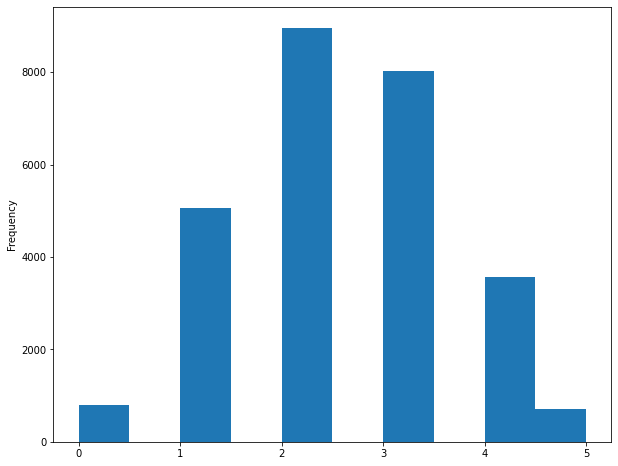

In [28]:
# number of tags per documents
docs.no_tags.plot.hist(figsize=(10, 8))
# most of the documents have 2 or 3 tags